# ABC analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
import datetime

In [3]:
df= pd.read_csv('../base/achatsV2.csv',sep=';')


Pour chaque id_produit, tu dois calculer :

La moyenne des quantités achetées

L’écart-type

Puis le coefficient de variation (CV)

In [5]:
# Vérifie les colonnes disponibles
print(df.columns)

# Exemple : suppose que les colonnes utiles sont 'id_produit' et 'quantite'
# Calcule le CV par produit
cv_df = df.groupby('id_produit')['quantité'].agg(['mean', 'std'])
cv_df['CV'] = cv_df['std'] / cv_df['mean']
cv_df = cv_df.reset_index()


Index(['id_achat', 'date_achat', 'id_produit', 'quantité', 'id_fournisseur',
       'prix_unitaire', 'délai_livraison_jours'],
      dtype='object')


**2. Classifier la variabilité : Haute ou Basse**
Utilise un seuil sur le CV, par exemple :

CV > 1 → Haute variabilité

CV ≤ 1 → Faible variabilité

python
Copier
Modifier


In [6]:
cv_df['variabilite'] = cv_df['CV'].apply(lambda x: 'HIGH' if x > 1 else 'LOW')


3. Calculer la valeur économique des produits
Utilise la valeur d’achat totale par produit (ou un autre indicateur économique pertinent comme CA, marge, etc.).

In [7]:
# Suppose qu'on a les colonnes 'prix_unitaire' et 'quantite'
df['valeur_totale'] = df['quantité'] * df['prix_unitaire']

# Total économique par produit
valeurs = df.groupby('id_produit')['valeur_totale'].sum().reset_index()
valeurs = valeurs.sort_values('valeur_totale', ascending=False)

# Classe ABC (selon 80/15/5 % de la valeur cumulée)
valeurs['part_cumulee'] = valeurs['valeur_totale'].cumsum() / valeurs['valeur_totale'].sum()

def get_classe(part):
    if part <= 0.8:
        return 'A'
    elif part <= 0.95:
        return 'B'
    else:
        return 'C'

valeurs['classe_economique'] = valeurs['part_cumulee'].apply(get_classe)


4. Fusionner les deux classifications

In [8]:
# Fusion des deux tableaux
segmentation = pd.merge(cv_df[['id_produit', 'variabilite']], valeurs[['id_produit', 'classe_economique']], on='id_produit')


5. Ajouter la segmentation finale (3 zones)

In [9]:
def get_segment(row):
    if row['variabilite'] == 'HIGH' and row['classe_economique'] in ['A', 'B']:
        return 'HIGH IMPORTANCE'
    elif row['variabilite'] == 'LOW' and row['classe_economique'] in ['A', 'B']:
        return 'STABLE DEMAND'
    else:
        return 'LOW IMPORTANCE'

segmentation['segment'] = segmentation.apply(get_segment, axis=1)


In [14]:
df.columns


Index(['id_achat', 'date_achat', 'id_produit', 'quantité', 'id_fournisseur',
       'prix_unitaire', 'délai_livraison_jours', 'valeur_totale'],
      dtype='object')

# Code adapté 

1. Importation des bibliothèques

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro


2. Chargement et préparation des données

In [21]:
# Chargement des données
df_achats = pd.read_csv('../base/achatsV2.csv', sep=';')

# Conversion de la date au format datetime
df_achats['date_achat'] = pd.to_datetime(df_achats['date_achat'], format='%d/%m/%Y')

# Calcul du montant total par ligne d'achat
df_achats['montant_total'] = df_achats['quantité'] * df_achats['prix_unitaire']

# Création d'un pivot pour analyser les achats par produit et par mois
df_achats['mois'] = df_achats['date_achat'].dt.to_period('M')


3. Analyse statistique par produit

In [22]:
# Groupement par produit pour analyses statistiques
stats_par_produit = df_achats.groupby('id_produit').agg(
    quantité_totale=('quantité', 'sum'),
    montant_total=('montant_total', 'sum'),
    nb_commandes=('id_achat', 'count'),
    quantité_moyenne=('quantité', 'mean'),
    quantité_std=('quantité', 'std'),
    prix_moyen=('prix_unitaire', 'mean'),
    délai_moyen=('délai_livraison_jours', 'mean')
)

# Calcul du coefficient de variation
stats_par_produit['CV'] = stats_par_produit['quantité_std'] / stats_par_produit['quantité_moyenne']

# Calcul de la normalité (test de Shapiro-Wilk)
def test_normalité(produit_id):
    quantités = df_achats[df_achats['id_produit'] == produit_id]['quantité']
    if len(quantités) < 3:  # Le test de Shapiro nécessite au moins 3 observations
        return 1.0  # Valeur par défaut pour éviter les erreurs
    stat, p = shapiro(quantités)
    return p

# Application du test de normalité pour chaque produit
stats_par_produit['Normalité_p'] = stats_par_produit.index.map(test_normalité)
stats_par_produit['Non_Normal'] = stats_par_produit['Normalité_p'] < 0.05


4. Segmentation ABC

In [23]:
# Calcul du pourcentage de contribution au montant total
total_achat = stats_par_produit['montant_total'].sum()
stats_par_produit['TO%'] = stats_par_produit['montant_total'] / total_achat * 100

# Tri par contribution décroissante
stats_abc = stats_par_produit.sort_values('TO%', ascending=False).copy()

# Calcul du pourcentage cumulé
stats_abc['TO%_CS'] = stats_abc['TO%'].cumsum()

# Attribution des identifiants SKU et pourcentages
stats_abc['SKU_ID'] = range(1, len(stats_abc) + 1)
stats_abc['SKU_%'] = stats_abc['SKU_ID'] / len(stats_abc) * 100

# Définition des seuils ABC (80-15-5)
to_a = 80  # 80% du CA
to_b = 95  # 95% du CA (15% suivants)
# Les 5% restants sont en C

# Attribution des catégories ABC
def attribuer_categorie_abc(row):
    if row['TO%_CS'] <= to_a:
        return 'A'
    elif row['TO%_CS'] <= to_b:
        return 'B'
    else:
        return 'C'

stats_abc['ABC'] = stats_abc.apply(attribuer_categorie_abc, axis=1)


5. Visualisation des résultats

Text(0.5, 1.0, 'Distribution par Variabilité de la Demande')

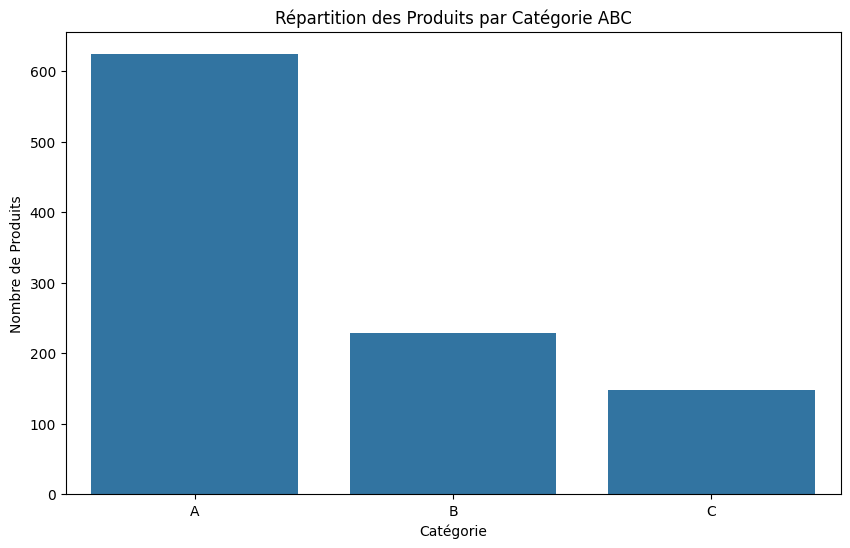

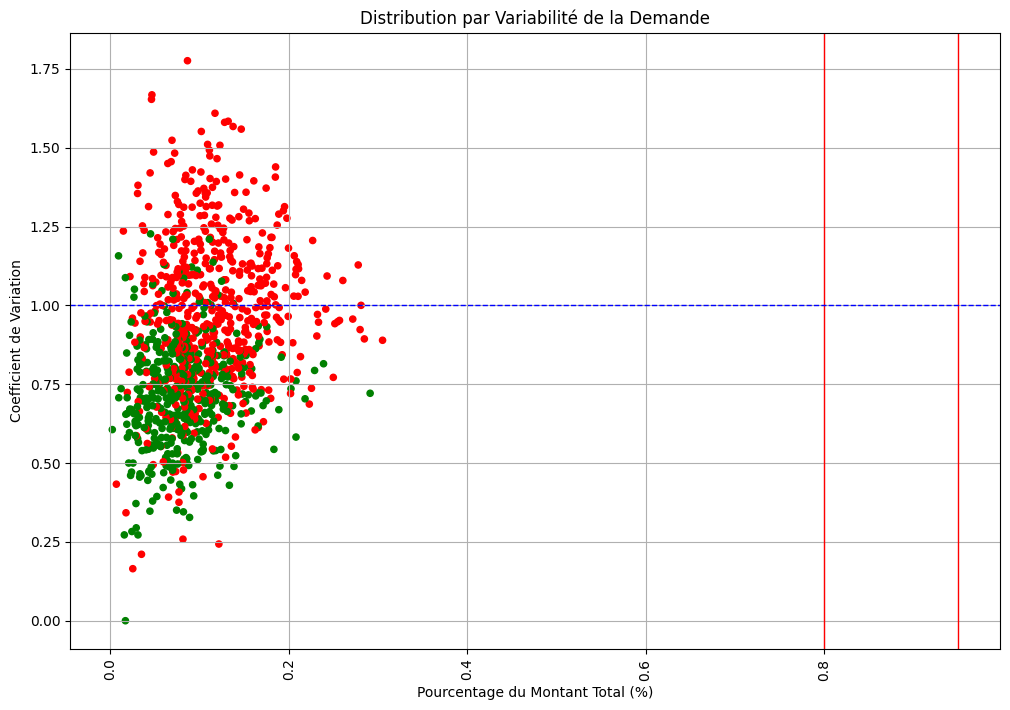

In [20]:
# Diagramme en barres pour la répartition ABC
plt.figure(figsize=(10, 6))
abc_counts = stats_abc['ABC'].value_counts()
sns.barplot(x=abc_counts.index, y=abc_counts.values)
plt.title('Répartition des Produits par Catégorie ABC')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de Produits')

# Graphique de dispersion TO% vs CV
plt.figure(figsize=(12, 8))
ax = plt.gca()
colors = {False: 'green', True: 'red'}
df_plot = stats_abc[stats_abc['CV'] < 4].copy()  # Filtrer les valeurs extrêmes de CV
df_plot.plot.scatter(x='TO%', y='CV', c=df_plot['Non_Normal'].map(colors), 
                    ax=ax, grid=True)

# Lignes de démarcation ABC
ax.axvline(to_a/100, color="red", linestyle="-", linewidth=1.0)
ax.axvline(to_b/100, color="red", linestyle="-", linewidth=1.0)

# Ligne pour la variabilité de demande
ax.axhline(1, color="blue", linestyle="--", linewidth=1.0)

plt.xlabel('Pourcentage du Montant Total (%)')
plt.xticks(rotation=90)
plt.ylabel('Coefficient de Variation')
plt.title('Distribution par Variabilité de la Demande')


Interprétation de la Segmentation ABC pour les Achats
Dans ce contexte d'analyse des achats, la segmentation ABC permet d'identifier:

Produits A: Représentent environ 80% du montant total des achats mais généralement une petite proportion du nombre total de références. Ces produits sont stratégiquement critiques et nécessitent une attention particulière dans la gestion des approvisionnements.

Produits B: Représentent environ 15% du montant total des achats et une proportion moyenne des références. Ces produits sont importants mais moins critiques que les produits A.

Produits C: Représentent environ 5% du montant total des achats mais souvent une grande proportion des références. Ces produits ont un impact financier limité mais peuvent nécessiter des ressources administratives significatives.

Le coefficient de variation (CV) permet d'analyser la stabilité des achats:

CV < 1: Demande relativement stable

CV > 1: Demande variable, nécessitant potentiellement des stratégies d'approvisionnement différentes

## MACHINE LEARNING achat_produit_fournisseur_stocks

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [25]:

# Chargement des données
df = pd.read_csv("../code/achat_prod_fournisseur_stock.csv")

df['date_achat'] = pd.to_datetime(df['date_achat'])

# Création de caractéristiques temporelles
df['mois_achat'] = df['date_achat'].dt.month
df['annee'] = df['date_achat'].dt.year
df['jour_semaine'] = df['date_achat'].dt.dayofweek
df['trimestre'] = df['date_achat'].dt.quarter


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_achat               10000 non-null  object        
 1   date_achat             10000 non-null  datetime64[ns]
 2   id_produit             10000 non-null  object        
 3   quantité               10000 non-null  int64         
 4   id_fournisseur         10000 non-null  object        
 5   prix_unitaire          10000 non-null  float64       
 6   délai_livraison_jours  10000 non-null  int64         
 7   montant_total          10000 non-null  float64       
 8   mois                   10000 non-null  int64         
 9   année                  10000 non-null  int64         
 10  jour_semaine           10000 non-null  int32         
 11  catégorie              10000 non-null  object        
 12  marque                 10000 non-null  object        
 13  pr

### Préprocessing 

In [26]:

# Identification des variables numériques et catégorielles
cat_features = ['id_produit', 'id_fournisseur', 'catégorie', 'marque', 
                'nom_fournisseur', 'ville', 'pays', 'entrepot']
num_features = ['prix_unitaire', 'fiabilité', 'stock_minimum', 'niveau_stock', 
                'délai_moyen_jours', 'prix']

# Préprocesseur pour transformer les variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


### Modèle de prévision de la demande


In [27]:
# Agrégation des données par produit et par mois pour la prévision
demand_data = df.groupby(['id_produit', 'année', 'mois'])['quantité'].sum().reset_index()

# Création de variables lag (historique des ventes précédentes)
for lag in [1, 2, 3, 6]:
    demand_data[f'lag_{lag}'] = demand_data.groupby('id_produit')['quantité'].shift(lag)

# Suppression des lignes avec valeurs manquantes (dues aux lags)
demand_data = demand_data.dropna()


In [31]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1171 entries, 6 to 6822
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_produit  1171 non-null   object 
 1   année       1171 non-null   int64  
 2   mois        1171 non-null   int64  
 3   quantité    1171 non-null   int64  
 4   lag_1       1171 non-null   float64
 5   lag_2       1171 non-null   float64
 6   lag_3       1171 non-null   float64
 7   lag_6       1171 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 82.3+ KB


In [29]:

# Identification des variables numériques et catégorielles
cat_features_ = ['id_produit']
num_features_ = ['mois', 'lag_1', 'lag_2', 'lag_3', 'lag_6']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_)
    ])

# Préparation des features et de la cible
X = demand_data.drop(['quantité'], axis=1)
y = demand_data['quantité']

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle XGBoost pour la prévision de demande
model_demand = Pipeline([
    ('preprocessor', preprocessor1),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5))
])

# Entraînement et évaluation
model_demand.fit(X_train, y_train)
y_pred = model_demand.predict(X_test)

# Métriques d'évaluation
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Analyse de l'importance des features
feature_importance = model_demand.named_steps['regressor'].feature_importances_

AttributeError: 'super' object has no attribute '__sklearn_tags__'

### Modèle d'estimation des délais fournisseurs


In [32]:
# Préparation des données pour le modèle de délai
X_delay = df[['id_fournisseur', 'quantité', 'catégorie', 'prix_unitaire','prix','fiabilité', 'mois', 'jour_semaine', 'pays', 'ville','entrepot']]
y_delay = df['délai_livraison_jours']

# Identification des variables numériques et catégorielles
cat_featuresf = ['id_fournisseur', 'catégorie','mois', 'jour_semaine','entrepot','ville', 'pays']
num_featuresf = ['prix_unitaire', 'fiabilité', 'prix','quantite']

# Préprocesseur pour transformer les variables
preprocessorf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_featuresf),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_featuresf)
    ])

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X_delay, y_delay, test_size=0.2, random_state=42)

# Modèle Random Forest pour la prédiction des délais
model_delay = Pipeline([
    ('preprocessor', preprocessorf),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

# Entraînement et évaluation
model_delay.fit(X_train, y_train)
y_pred = model_delay.predict(X_test)

# Métriques d'évaluation
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

ValueError: A given column is not a column of the dataframe

In [33]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Pour le modèle de prévision de demande (validation temporelle)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model_demand, X, y, cv=tscv, scoring='neg_mean_absolute_error')
print(f"MAE CV: {-np.mean(cv_scores)}")

# Pour le modèle de délai (validation standard)
cv_scores = cross_val_score(model_delay, X_delay, y_delay, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE CV: {-np.mean(cv_scores)}")


c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py", line 242, in _get_response_values
    y_pred, 

MAE CV: nan


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'quantite'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_indexing.py", line 364, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'quantite'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Djo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_indexing.py", line 372, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


## Random Forest

In [34]:
# Feature Engineering avancé
df['demande_rolling_30j'] = df.groupby('id_produit')['quantité'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)
df['pression_stock'] = df['niveau_stock'] / df['stock_minimum']


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_achat               10000 non-null  object        
 1   date_achat             10000 non-null  datetime64[ns]
 2   id_produit             10000 non-null  object        
 3   quantité               10000 non-null  int64         
 4   id_fournisseur         10000 non-null  object        
 5   prix_unitaire          10000 non-null  float64       
 6   délai_livraison_jours  10000 non-null  int64         
 7   montant_total          10000 non-null  float64       
 8   mois                   10000 non-null  int64         
 9   année                  10000 non-null  int64         
 10  jour_semaine           10000 non-null  int64         
 11  catégorie              10000 non-null  object        
 12  marque                 10000 non-null  object        
 13  pr

In [44]:
retours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2987 entries, 0 to 2986
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_commande  2987 non-null   object        
 1   id_produit   2987 non-null   object        
 2   date_retour  2987 non-null   datetime64[ns]
 3   motif        2987 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 93.5+ KB


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, roc_auc_score

# 1. Chargement des données
df = pd.read_csv('../code/achat_prod_fournisseur_stock.csv')
# Supposons une table retours dans retours.csv
retours = pd.read_csv('../base/retoursV2.csv', sep=';')
df['date_achat'] = pd.to_datetime(df['date_achat'])
retours['date_retour'] = pd.to_datetime(retours['date_retour'])
# 2. Calcul des KPI
# 2.1 Rupture de stock
df['rupture_flag'] = (df['niveau_stock'] < df['stock_minimum']).astype(int)
kpi_rupture = df.groupby('id_produit')['rupture_flag'].mean().reset_index(name='taux_rupture_pct')

# 2.2 OTIF
# OnTimeFlag et FullFlag
df['on_time'] = (df['date_livraison'] <= df['date_attendue']).astype(int)
df['full']    = (df['quant_livree'] >= df['quant_attendue']).astype(int)
df['otif_flag'] = df['on_time'] * df['full']
kpi_otif     = df['otif_flag'].mean() * 100

# 2.3 Taux de retour
ret_total = retours.groupby('id_commande')['quantite_retournee'].sum().reset_index()
deliv_total = df.groupby('id_commande')['quant_livree'].sum().reset_index()
ret = ret_total.merge(deliv_total, on='id_commande')
kpi_taux_retour = (ret['quantite_retournee'].sum() / ret['quant_livree'].sum()) * 100

# 2.4 Délai moyen expédition
df['delai_jours'] = (df['date_livraison'] - df['date_expedition']).dt.days
kpi_delai_moyen = df['delai_jours'].mean()

# 2.5 Stock turnover
# consommation annuelle et stock moyen
consommation = df.groupby(df['date_achat'].dt.year)['quant_achetee'].sum().iloc[-1]
stock_jan1 = df[df['date_achat'] == pd.to_datetime(f"{df['date_achat'].dt.year.max()}-01-01")]['niveau_stock'].mean()
stock_dec31 = df[df['date_achat'] == pd.to_datetime(f"{df['date_achat'].dt.year.max()}-12-31")]['niveau_stock'].mean()
stock_moyen = (stock_jan1 + stock_dec31) / 2
kpi_rotation = consommation / stock_moyen

# 2.6 Coût logistique unitaire
kpi_cout_unitaire = df['cout_transport'].sum() / df['quant_livree'].sum()

# 2.7 Fill Rate
df['fill_rate'] = df['quant_livree'] / df['quant_attendue']
kpi_fill_rate = df['fill_rate'].mean() * 100

# Agrégation des KPI globaux
glob_kpis = pd.DataFrame({
    'otif_pct': [kpi_otif],
    'taux_retour_pct': [kpi_taux_retour],
    'delai_moyen_jours': [kpi_delai_moyen],
    'rotation_stock': [kpi_rotation],
    'cout_unitaire': [kpi_cout_unitaire],
    'fill_rate_pct': [kpi_fill_rate]
})

# 3. Feature Engineering pour ML
# Ajout de variables temporelles
df['jour_semaine'] = df['date_achat'].dt.dayofweek
df['mois']         = df['date_achat'].dt.month
# Moyenne mobile du niveau stock
df = df.sort_values('date_achat')
df['stock_mm_7'] = df.groupby('id_produit')['niveau_stock'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Merge kpi_rupture sur df
df = df.merge(kpi_rupture, on='id_produit', how='left')

# 4. Cas d'usage: prédiction du délai fournisseur (Régression)
features = ['jour_semaine', 'mois', 'niv...']  # compléter
X = df[features]
y = df['delai_jours']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
print('MAE délai:', mean_absolute_error(y_test, pred))

# 5. Cas d'usage: classification retour
# Préparation dataset retour vs non-retour
df_class = df.merge(ret[['id_commande','quantite_retournee']], on='id_commande', how='left').fillna(0)
df_class['retour_flag'] = (df_class['quantite_retournee']>0).astype(int)
Xc = df_class[features]
yc = df_class['retour_flag']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict_proba(Xc_test)[:,1]
print('ROC AUC retour:', roc_auc_score(yc_test, yc_pred))

# Export des KPI pour reporting
glob_kpis.to_csv('kpi_supply_chain.csv', index=False)


KeyError: 'date_livraison'

## Other model